In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pandas as pd
import numpy as np
import lstm, time #도움을 주는 라이브러리들

Using TensorFlow backend.


In [2]:
df = pd.read_csv('lg전자.csv', header='infer')
df.describe()
df['Gap'] = (df['Close'] - df['Open']) / (df['High'] - df['Low'])
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df

,Date,Open,High,Low,Close,Volume,Change,Gap
1,2001-04-26,17918,18416,17492,17636,1197840,-0.046136,-0.305195
2,2001-04-27,17280,18204,17066,18062,854340,0.024155,0.687170
3,2001-04-30,17706,18275,17706,18204,803230,0.007862,0.875220
4,2001-05-02,18345,18843,17990,18489,851580,0.015656,0.168816
5,2001-05-03,18631,21262,18417,21262,3525520,0.149981,0.924780
...,...,...,...,...,...,...,...,...
4853,2020-12-10,822000,833000,815000,817000,615054,-0.022727,-0.277778
4854,2020-12-11,825000,827000,808000,808000,363164,-0.011016,-0.894737
4855,2020-12-14,811000,811000,791000,793000,332473,-0.018564,-0.900000
4856,2020-12-15,802000,804000,794000,801000,300410,0.010088,-0.100000


In [3]:
df['일자'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['연도'] = df['일자'].dt.year
df['월'] =df['일자'].dt.month
df['일'] =df['일자'].dt.day
df

,Date,Open,High,Low,Close,Volume,Change,Gap,일자,연도,월,일
1,2001-04-26,17918,18416,17492,17636,1197840,-0.046136,-0.305195,2001-04-26,2001,4,26
2,2001-04-27,17280,18204,17066,18062,854340,0.024155,0.687170,2001-04-27,2001,4,27
3,2001-04-30,17706,18275,17706,18204,803230,0.007862,0.875220,2001-04-30,2001,4,30
4,2001-05-02,18345,18843,17990,18489,851580,0.015656,0.168816,2001-05-02,2001,5,2
5,2001-05-03,18631,21262,18417,21262,3525520,0.149981,0.924780,2001-05-03,2001,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...
4853,2020-12-10,822000,833000,815000,817000,615054,-0.022727,-0.277778,2020-12-10,2020,12,10
4854,2020-12-11,825000,827000,808000,808000,363164,-0.011016,-0.894737,2020-12-11,2020,12,11
4855,2020-12-14,811000,811000,791000,793000,332473,-0.018564,-0.900000,2020-12-14,2020,12,14
4856,2020-12-15,802000,804000,794000,801000,300410,0.010088,-0.100000,2020-12-15,2020,12,15


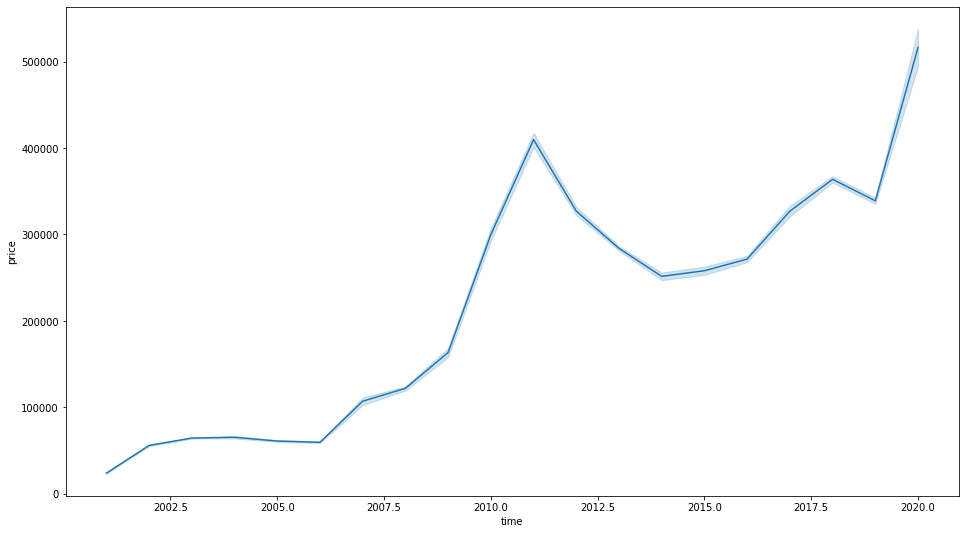

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['Close'], x=df['연도'])
plt.xlabel('time')
plt.ylabel('price')
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close','Gap','Volume','Change']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

          Open      High       Low     Close       Gap    Volume    Change
0     0.000754  0.000251  0.000514  0.000000  0.346915  0.288970  0.364482
1     0.000000  0.000000  0.000000  0.000514  0.842400  0.201525  0.557931
2     0.000504  0.000084  0.000772  0.000686  0.936293  0.188515  0.513090
3     0.001259  0.000756  0.001115  0.001030  0.583587  0.200823  0.534540
4     0.001597  0.003620  0.001630  0.004377  0.961038  0.881523  0.904221
...        ...       ...       ...       ...       ...       ...       ...
4836  0.951521  0.964488  0.962603  0.964991  0.360604  0.140611  0.428904
4837  0.955068  0.957386  0.954158  0.954126  0.052558  0.076488  0.461136
4838  0.938514  0.938447  0.933650  0.936018  0.049930  0.068675  0.440361
4839  0.927872  0.930161  0.937269  0.945676  0.449368  0.060513  0.519217
4840  0.939696  0.951468  0.954158  0.962577  0.606290  0.037491  0.539555

[4841 rows x 7 columns]


In [6]:
train = df_scaled[:int(len(df_scaled)* 0.8)]
test = df_scaled[int(len(df_scaled)* 0.8):]
len(train), len(test)

(3872, 969)

In [7]:
def make_dataset(data, label, window_size=40):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [8]:
feature_cols = ['Open']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 40)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(x_train.shape, x_valid.shape)

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 40)
print(test_feature.shape, test_label.shape)

(3065, 40, 1) (767, 40, 1)
(929, 40, 1) (929, 1)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(128, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [10]:
import os
model_path = 'C:/Tein'
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)  
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
189/192 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00001: val_loss improved from inf to 0.00015, saving model to C:/Tein\tmp_checkpoint.h5
192/192 [==============================] - 3s 17ms/step - loss: 0.0021 - val_loss: 1.5434e-04
Epoch 2/200
192/192 [==============================] - ETA: 0s - loss: 1.9011e-04
Epoch 00002: val_loss did not improve from 0.00015
192/192 [==============================] - 3s 16ms/step - loss: 1.9011e-04 - val_loss: 3.6435e-04
Epoch 3/200
189/192 [============================>.] - ETA: 0s - loss: 2.0655e-04
Epoch 00003: val_loss improved from 0.00015 to 0.00015, saving model to C:/Tein\tmp_checkpoint.h5
192/192 [==============================] - 3s 16ms/step - loss: 2.0577e-04 - val_loss: 1.4699e-04
Epoch 4/200
191/192 [============================>.] - ETA: 0s - loss: 1.6070e-04
Epoch 00004: val_loss improved from 0.00015 to 0.00013, saving model to C:/Tein\tmp_checkpoint.h5
192/192 [==============================] - 3s

In [11]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

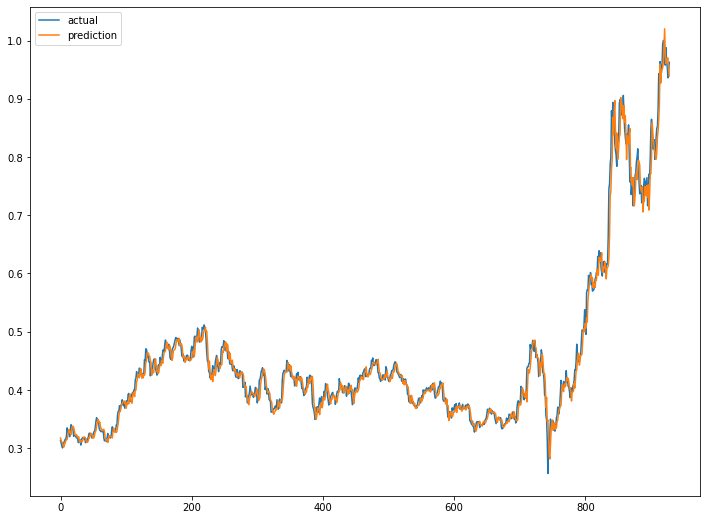

In [12]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()